In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.optimize as opt
import time
import yaml
import matplotlib.ticker as ticker
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation




Suitable as a BESS to buy, store, sell

Must register as a licensed electricity generator or trader

In [2]:

def load_price_data(filepath, datetime_col=None, price_cols=None):
    """
    Load electricity price data from a CSV file.

    Parameters
    ----------
    filepath : str
        Path to the CSV file.
    datetime_col : str, optional
        Name of the column containing datetime information (will be parsed).
    price_cols : list of str, optional
        List of column names to keep (e.g. ['SBP', 'SSP']).

    Returns
    -------
    pd.DataFrame
        Cleaned DataFrame with datetime index (if provided).
    """
    # Read CSV
    df = pd.read_csv(filepath)

    # If a datetime column is provided, parse it
    if datetime_col:
        df[datetime_col] = pd.to_datetime(df[datetime_col])
        df.set_index(datetime_col, inplace=True)

    # Keep only relevant price columns if specified
    if price_cols:
        missing = [col for col in price_cols if col not in df.columns]
        if missing:
            raise ValueError(f"Missing columns in CSV: {missing}")
        df = df[price_cols]

    # Handle missing values (optional: forward fill then drop remaining)
    df = df.ffill().dropna()

    return df

In [3]:
def replay_feed(data, delay=0.0):
    """
    Simulate a live feed from historical data.
    
    Parameters
    ----------
    data : pd.DataFrame
        Time-indexed DataFrame with electricity prices.
    delay : float
        Seconds to wait between timesteps (simulated real-time).
    
    Yields
    ------
    (timestamp, row) : tuple
        Each row of data with its timestamp.
    """
    for timestamp, row in data.iterrows():
        yield timestamp, row
        time.sleep(delay)  # wait before sending the next tick


In [6]:
def load_config(filepath):
    with open(filepath, "r") as f:
        config = yaml.safe_load(f)
    return config

# Load configuration files
battery_cfg = load_config('BatteryConfig.yaml')
trading_cfg = load_config('TradingConfig.yaml')
# Extract battery parameters        
battery_capacity = battery_cfg['battery']['capacity_kwh']
max_charge_kw = battery_cfg['battery']['max_charge_kw']
max_discharge_kw = battery_cfg['battery']['max_discharge_kw']
efficiency = battery_cfg['battery']['efficiency']
soc_init = battery_cfg['battery']['soc_init']
degradation_rate = battery_cfg['battery']['degradation_rate']
# Extract trading parameters
starting_balance = trading_cfg['trading']['starting_balance']
transaction_fee = trading_cfg['trading']['transaction_fee']
max_trade_volume = trading_cfg['trading']['max_trade_volume']


In [7]:

# df = pd.read_csv("SystemSellAndBuyPrices-2025-06-29T12_30_00.000Z-2025-07-06T12_30_00.000Z.csv", parse_dates=["SettlementDate"])
ssp_df = pd.read_csv("SystemSellAndBuyPrices-2017-01-01T00_00_00.000Z-2017-01-08T00_00_00.000Z.csv", parse_dates=["StartTime"])

demand_df = pd.read_csv("RollingSystemDemand-2017-01-01T00_00_00.000Z-2017-01-08T14_30_00.000Z.csv", parse_dates=["StartTime"])

# print(ssp_df.head())
# print(demand_df.head())

merged_df = pd.merge(ssp_df, demand_df[['StartTime', 'Demand']], on='StartTime', how='inner')
df = merged_df

# merged_df


# df.set_index("SettlementDate", inplace=True)
# # df = df[(df["SystemBuyPrice"] > 0) | (df["SystemSellPrice"] > 0)]

# ssp_df['Timestamp'] = pd.to_datetime(ssp_df['Timestamp'])
# demand_df['Timestamp'] = pd.to_datetime(demand_df['Timestamp'])

# # Merge on Timestamp (inner join keeps only matching times)
# merged_df = pd.merge(ssp_df, demand_df, on='Timestamp', how='inner')



# for ts, prices in replay_feed(df, delay=0.5):
#     sbp = prices["SystemBuyPrice"]
#     ssp = prices["SystemSellPrice"]



#     #### Decision Making Logic code Here ######








    

#     # Example decision rule (very basic!)
#     decision = "HOLD"
#     if ssp < 50 and capacity < (battery_capacity - trading_vol) and balance -ssp > 0:  # cheap → buy
#         decision = "BUY"
#         paid_price = (ssp * trading_vol * (1 + transaction_fee))
#         balance = balance - paid_price
#         capacity = battery_capacity + trading_vol
        
#     elif sbp > 70 and (capacity - trading_vol) > 0:  # expensive → sell
#         decision = "SELL"
#         sale_price = (sbp * trading_vol * (1 + transaction_fee))
#         balance = balance + paid_price
#         capacity = battery_capacity - trading_vol

#     # print(f"{ts} | SystemBuyPrice={sbp:.2f}, SystemSellPrice={ssp:.2f} → {decision}   | Balance={balance:.2f}, Capacity={capacity:.2f} kWh")
# print(f"Final Balance: {balance:.2f}, Final Capacity: {capacity:.2f} MWh")  # Final summary

In [8]:
##### Price Features
df["ssp_lag1"] = df["SystemSellPrice"].shift(1)
df["ssp_lag2"] = df["SystemSellPrice"].shift(2)
df["ssp_ma6"]  = df["SystemSellPrice"].rolling(6).mean()
df["sbp_ma6"]  = df["SystemBuyPrice"].rolling(6).mean()
df["ssp_rolling_mean_48"] = df["SystemSellPrice"].rolling(48).mean()
df["spread"]   = df["SystemBuyPrice"] - df["SystemSellPrice"]
df['ssp_rolling_std_3']  = df['SystemSellPrice'].rolling(3).std()

##### Demand Features
df["Demand_lag1"] = df["Demand"].shift(1)
df["Demand_lag2"] = df["Demand"].shift(2)
df["Demand_ma6"]  = df["Demand"].rolling(6).mean()
df["Demand_rolling_std_3"] = df["Demand"].rolling(3).std()

##### Time Features
df['hour'] = df['StartTime'].dt.hour
df['day_of_week'] = df['StartTime'].dt.dayofweek  # 0=Monday
df['month'] = df['StartTime'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int) 

##### Battery Features
df["Battery_Level"] = soc_init  # Initial state of charge

##### Market Dynamics
df['is_price_spike'] = (df['SystemSellPrice'] > df['ssp_rolling_mean_48']*1.5).astype(int)



In [9]:

# Volatility Calculation
df["MidPrice"] = (df["SystemSellPrice"] + df["SystemBuyPrice"]) / 2
df["Return"] = np.log(df["MidPrice"] / df["MidPrice"].shift(1)) # Volatility is computed from log returns
df["RollingVol"] = df["Return"].rolling(window=48).std() * np.sqrt(48) # Annualize the volatility
df["RollingVol"]
df.dropna()

,SettlementDate,SettlementPeriod,StartTime,CreatedDateTime,SystemSellPrice,SystemBuyPrice,BsadDefaulted,PriceDerivationCode,ReserveScarcityPrice,NetImbalanceVolume,...,Demand_rolling_std_3,hour,day_of_week,month,is_weekend,Battery_Level,is_price_spike,MidPrice,Return,RollingVol
71,2017-01-02,24,2017-01-02 11:30:00+00:00,2017-01-02T12:21:39Z,39.00000,39.00000,False,N,0.0000,-436.14580,...,123.613645,11,0,1,0,0.5,0,39.00000,0.006362,1.707623
111,2017-01-03,16,2017-01-03 07:30:00+00:00,2017-01-03T08:21:42Z,21.00000,21.00000,False,N,0.0000,-444.57790,...,2873.762052,7,1,1,0,0.5,0,21.00000,-0.580947,2.156873
112,2017-01-03,17,2017-01-03 08:00:00+00:00,2017-01-03T08:51:40Z,33.00000,33.00000,False,N,0.0000,-411.56820,...,2189.460436,8,1,1,0,0.5,0,33.00000,0.451985,2.206385
226,2017-01-05,35,2017-01-05 17:00:00+00:00,2017-01-05T17:51:41Z,39.50000,39.50000,False,N,0.0021,-301.75452,...,1717.339318,17,3,1,0,0.5,0,39.50000,-0.001422,3.186254
227,2017-01-05,36,2017-01-05 17:30:00+00:00,2017-01-05T18:21:40Z,39.11891,39.11891,False,N,0.0024,-346.49130,...,647.943156,17,3,1,0,0.5,0,39.11891,-0.009695,3.186268
309,2017-01-07,22,2017-01-07 10:30:00+00:00,2017-01-07T11:21:48Z,49.19000,49.19000,False,P,0.0000,148.24380,...,562.068501,10,5,1,1,0.5,0,49.19000,-0.804790,2.104468
310,2017-01-07,23,2017-01-07 11:00:00+00:00,2017-01-07T11:51:49Z,52.71000,52.71000,False,P,0.0000,114.95830,...,359.864326,11,5,1,1,0.5,0,52.71000,0.069115,2.061709
311,2017-01-07,24,2017-01-07 11:30:00+00:00,2017-01-07T12:21:49Z,69.95000,69.95000,False,P,0.0000,196.07180,...,383.244482,11,5,1,1,0.5,0,69.95000,0.282976,2.082553
312,2017-01-07,25,2017-01-07 12:00:00+00:00,2017-01-07T12:51:46Z,69.95000,69.95000,False,P,0.0000,295.07240,...,320.041143,12,5,1,1,0.5,0,69.95000,0.000000,2.077082
313,2017-01-07,26,2017-01-07 12:30:00+00:00,2017-01-07T13:21:49Z,53.81000,53.81000,False,P,0.0000,280.00000,...,53.113087,12,5,1,1,0.5,0,53.81000,-0.262321,2.088905


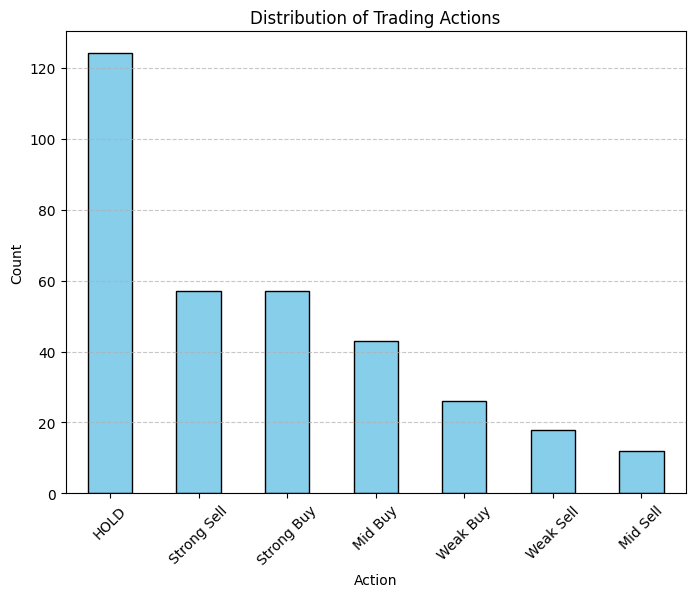

In [10]:
# Simple mechanism

def SimpleMechanism(df=df):
    threshold = df["SystemSellPrice"].rolling(window=48).std().mean()*0.75
    df['Action'] = np.where(df["SystemSellPrice"] < df["ssp_ma6"] - threshold, 'Buy', 
                            np.where(df["SystemSellPrice"] > df["ssp_ma6"] + threshold, "Sell", "HOLD"))
    return df['Action']

# SimpleMechanism(df)

## More complex, with different levels of strong, mid, weak buy/sell
def ComplexMechanism(df=df):
    threshold = df["SystemSellPrice"].rolling(window=48).std().mean() * 0.3
    df['Action'] = np.where(df["SystemSellPrice"] < df["ssp_ma6"] - threshold*2, 'Strong Buy',
                            np.where(df["SystemSellPrice"] < df["ssp_ma6"] - threshold, 'Mid Buy',
                                np.where(df["SystemSellPrice"] < df["ssp_ma6"] - threshold * 0.5, 'Weak Buy',
                                    np.where(df["SystemSellPrice"] > df["ssp_ma6"] + threshold * 2, 'Strong Sell',
                                        np.where(df["SystemSellPrice"] > df["ssp_ma6"] + threshold, 'Mid Sell',
                                                 np.where(df["SystemSellPrice"] > df["ssp_ma6"] + threshold * 0.5, "Weak Sell", 'HOLD'))))))
                            
    return df['Action']

ComplexMechanism(df)

df['Action'] = ComplexMechanism(df)

# Count occurrences of each action
action_counts = df['Action'].value_counts()

# Plot as a bar chart
plt.figure(figsize=(8,6))
action_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Distribution of Trading Actions")
plt.xlabel("Action")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [11]:
##### Grid Search To find suitable parameters for Random Forest Classifier

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Example RandomForest
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],      # number of trees
    'max_depth': [None, 10, 20, 30, 40],     # depth of trees
    'min_samples_split': [2, 5, 10, 20],     # min samples to split a node
    'min_samples_leaf': [1, 2, 4, 8],       # min samples per leaf
    'max_features': ['sqrt', 'log2']     # number of features to consider
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                # 5-fold cross-validation
    n_jobs=-1,           # use all CPU cores
    verbose=2,
    scoring='f1_macro'   # f1_macro balances across classes
)

# Fit to training data
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Get the best model
best_rf = grid_search.best_estimator_

# Test it on holdout data
y_pred = best_rf.predict(X_test)

NameError: name 'X_train' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Features and labels
X = df[['SystemSellPrice', 'ssp_lag1', 'ssp_lag2', 'ssp_ma6', 'hour', 'day_of_week', 'month',
         'is_weekend', 'Battery_Level', 'Demand_lag1', 'Demand_lag2', 'Demand_ma6', 'Demand_rolling_std_3',
           'ssp_rolling_mean_48', 'ssp_rolling_std_3']]
y = df['Action']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Run_params = grid_search.best_params_

# Train Random Forest
rf = RandomForestClassifier(**Run_params)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        HOLD       0.80      1.00      0.89        16
     Mid Buy       0.67      0.50      0.57        12
    Mid Sell       0.00      0.00      0.00         1
  Strong Buy       0.76      0.94      0.84        17
 Strong Sell       0.78      0.93      0.85        15
    Weak Buy       0.00      0.00      0.00         6
   Weak Sell       0.00      0.00      0.00         1

    accuracy                           0.76        68
   macro avg       0.43      0.48      0.45        68
weighted avg       0.67      0.76      0.71        68



c:\Users\willi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\willi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\willi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

HOLD: 5000.00 kWh, Profit: 0.00 £
HOLD: 5000.00 kWh, Profit: 0.00 £
HOLD: 5000.00 kWh, Profit: 0.00 £
HOLD: 5000.00 kWh, Profit: 0.00 £
HOLD: 5000.00 kWh, Profit: 0.00 £
HOLD: 5000.00 kWh, Profit: 0.00 £
HOLD: 5000.00 kWh, Profit: 0.00 £
HOLD: 5000.00 kWh, Profit: 0.00 £
HOLD: 5000.00 kWh, Profit: 0.00 £
HOLD: 5000.00 kWh, Profit: 0.00 £
Strong Sell: 4000.00 kWh, Profit: 63.93 £
Weak Buy: 4485.00 kWh, Profit: 44.68 £
Weak Buy: 4970.00 kWh, Profit: 25.63 £
Weak Buy: 5455.00 kWh, Profit: 6.50 £
Weak Buy: 5940.00 kWh, Profit: -12.75 £
Mid Buy: 6667.50 kWh, Profit: -38.30 £
Mid Buy: 7395.00 kWh, Profit: -57.05 £
HOLD: 7395.00 kWh, Profit: -57.05 £
Weak Sell: 6895.00 kWh, Profit: -37.80 £
Strong Sell: 5895.00 kWh, Profit: 26.15 £
HOLD: 5895.00 kWh, Profit: 26.15 £
Weak Buy: 6380.00 kWh, Profit: 9.46 £
HOLD: 6380.00 kWh, Profit: 9.46 £
HOLD: 6380.00 kWh, Profit: 9.46 £
HOLD: 6380.00 kWh, Profit: 9.46 £
HOLD: 6380.00 kWh, Profit: 9.46 £
HOLD: 6380.00 kWh, Profit: 9.46 £
HOLD: 6380.00 kWh, Pro

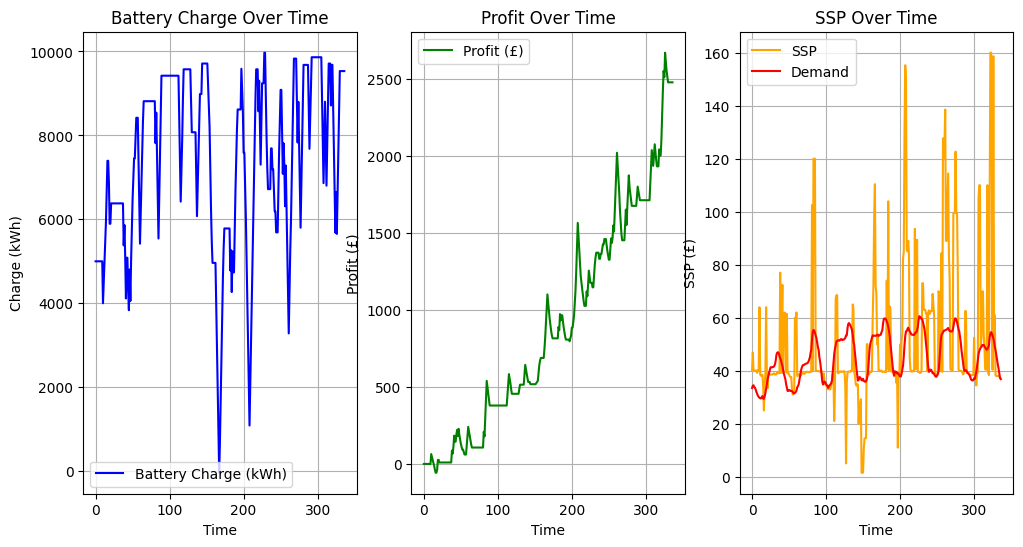

In [ ]:
# Example: simulate decisions
df['Predicted_Action'] = rf.predict(X)

# Track battery state
capacity = 10000  # kWh
charge = capacity * 0.5    # start half full
efficiency = 0.97
charge_list = []
profit_list = []
charge_sale_vol = 100
Capacity_remaining = capacity - charge

Strong = 0.2
Mid = 0.15
Weak = 0.1

StrongBuyVol =  Capacity_remaining * Strong
MidBuyVol = Capacity_remaining * Mid
WeakBuyVol = Capacity_remaining * Weak

StrongSellVol = charge * Strong
MidSellVol = charge * Mid
WeakSellVol = charge * Weak

# ## Simple Model

# profit = 0
# for i, row in df.iterrows():
#     action = row['Predicted_Action']
#     price = row['SystemSellPrice'] * 0.001  # Convert to £/kWh

    
#     if action == 'Buy' and charge < (capacity- charge_sale_vol):
#         charge += charge_sale_vol * efficiency
#         profit -= price * charge_sale_vol

#     elif action == 'Sell' and (charge + charge_sale_vol) > 0:
#         charge -= charge_sale_vol
#         profit += price * charge_sale_vol
#     charge_list.append(charge)
#     profit_list.append(profit)


### More Complex Model, with more stages of buying
profit = 0

for i, row in df.iterrows():
    action = row['Predicted_Action']
    price = row['SystemSellPrice'] * 0.001  # Convert to £/kWh
    
    if action == 'Strong Buy' and charge < (capacity- StrongBuyVol):
        charge += StrongBuyVol * efficiency
        profit -= price * StrongBuyVol
        print(f"Strong Buy: {charge:.2f} kWh, Profit: {profit:.2f} £")

    elif action == 'Mid Buy' and charge < (capacity- MidBuyVol):
        charge += MidBuyVol * efficiency
        profit -= price * MidBuyVol
        print(f"Mid Buy: {charge:.2f} kWh, Profit: {profit:.2f} £")
    
    elif action == 'Weak Buy' and charge < (capacity- WeakBuyVol):
        charge += WeakBuyVol * efficiency
        profit -= price * WeakBuyVol
        print(f"Weak Buy: {charge:.2f} kWh, Profit: {profit:.2f} £")

    elif action == 'Weak Sell' and (charge + WeakSellVol) > 0:
        charge -= WeakSellVol
        profit += price * WeakSellVol
        print(f"Weak Sell: {charge:.2f} kWh, Profit: {profit:.2f} £")

    elif action == 'Mid Sell' and (charge + MidSellVol) > 0:
        charge -= MidSellVol
        profit += price * MidSellVol
        print(f"Mid Sell: {charge:.2f} kWh, Profit: {profit:.2f} £")

    elif action == 'Strong Sell' and (charge + StrongSellVol) > 0:
        charge -= StrongSellVol
        profit += price * StrongSellVol
        print(f"Strong Sell: {charge:.2f} kWh, Profit: {profit:.2f} £")

    elif action == 'HOLD':
        charge += 0
        profit += 0
        print(f"HOLD: {charge:.2f} kWh, Profit: {profit:.2f} £")
    charge_list.append(charge)
    profit_list.append(profit)
    
# endprofit = profit + charge * price  # Final profit including remaining charge

print(f"Simulated Profit: £{profit:.2f}")
print(f"Battery Charge: {charge:.2f} kWh")
# print(f"Final Profit including charge: £{endprofit:.2f}")
fig, ax = plt.subplots(1,3,figsize=(12, 6))
ax[0].plot(df.index, charge_list, label='Battery Charge (kWh)', color='blue')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Charge (kWh)')
ax[0].set_title('Battery Charge Over Time')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(df.index, profit_list, label='Profit (£)', color='green')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Profit (£)')
ax[1].set_title('Profit Over Time')
ax[1].legend()
ax[1].grid(True)  

ax[2].plot(df.index, df['SystemSellPrice'], label='SSP', color='orange')
ax[2].plot(df.index, df['Demand']*0.0012, label='Demand', color='red')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('SSP (£)')
ax[2].set_title('SSP Over Time')
ax[2].legend()
ax[2].grid(True)

# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Battery Charge and Profit Over Time')
# plt.legend()
# plt.show()

In [ ]:
# from ElexonDataPortal import api
# import pandas as pd

# client = api.Client("YOUR_API_KEY")

# # Fetch imbalance prices (SBP/SSP) via the imbalance stream (B1770, NOT B1720)
# df = client.get_B1770(
#     start_date="2016-01-01",
#     end_date="2016-02-01",
#     # service_type="csv"
# )

# df["StartTime"] = pd.to_datetime(df["StartTime"])
# df = df.sort_values("StartTime").reset_index(drop=True)
# print(df.head())


c:\Users\willi\AppData\Local\Programs\Python\Python313\Lib\site-packages\ElexonDataPortal\dev\utils.py:99: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dt_rng = pd.date_range(extended_start_date, extended_end_date, freq=freq, tz=tz)
B1770:   0%|          | 0/1535 [00:00<?, ?it/s]

ConnectionError: HTTPSConnectionPool(host='api.bmreports.com', port=443): Max retries exceeded with url: /BMRS/B1770/v1?APIKey=YOUR_API_KEY&SettlementDate=2016-01-01&Period=1&ServiceType=xml (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000202F1B43D90>: Failed to resolve 'api.bmreports.com' ([Errno 11001] getaddrinfo failed)"))

In [ ]:
# df_test = client.get_B1770(
#     PublishDateTimeFrom="2016-01-01T00:00:00Z",
#     PublishDateTimeTo="2016-01-03T00:00:00Z",
#     service_type="csv"
# )
# print(df_test.head())

TypeError: Client.get_B1770() got an unexpected keyword argument 'PublishDateTimeFrom'